# Cluster Model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import pickle
import config as cfg

## Data Import

In [2]:
!ls pickles

clustered_replays.pickle player_races.pickle      raw_train_builds.pickle
memo_tree.pickle         raw_id_list.pickle       test_replays.pickle
obs_id_list.pickle       raw_obs.pickle           unit_counts.pickle


In [3]:
unit_counts = cfg.from_pickle('pickles/unit_counts.pickle')
player_races = cfg.from_pickle('pickles/player_races.pickle')

In [4]:
player_races.name = 'race'

## Feature Engineering

In [5]:
for column in unit_counts.columns:
    minerals = cfg.unit_costs[column]['minerals']
    gas = cfg.unit_costs[column]['gas']
    cost = minerals + gas * 2
    
    unit_counts[column] = unit_counts[column] * cost

In [6]:
label_unit_df = unit_counts.copy()
label_unit_df.columns = [cfg.cluster_unit_dict[col] for col in label_unit_df.columns]

## Hierarchical clustering

### Terran

In [7]:
terran_df = label_unit_df[player_races==1]

In [8]:
from scipy.cluster.hierarchy import dendrogram, linkage

Z = linkage(terran_df,'ward')
plt.figure(dpi=500,figsize=(30,30))
dendrogram(Z,truncate_mode='mlab',);

In [9]:
from sklearn.cluster import AgglomerativeClustering

clustering = AgglomerativeClustering(linkage='ward', n_clusters=7,distance_threshold=None)
terran_cluster = clustering.fit_predict(terran_df)
terran_cluster_df = terran_df.copy()
terran_cluster_df['labels'] = terran_cluster
terran_cluster_count = len(terran_cluster_df['labels'].unique())

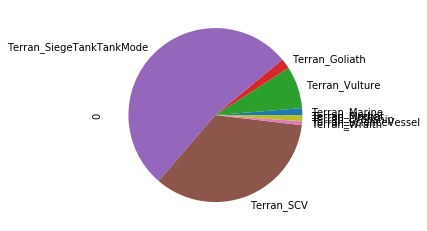

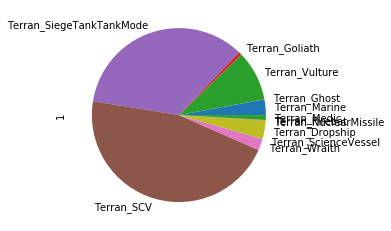

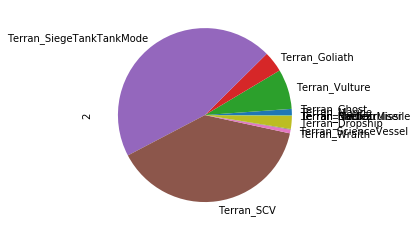

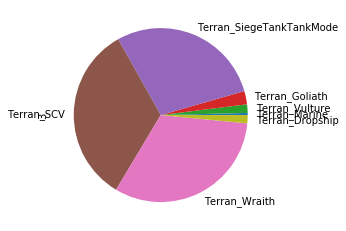

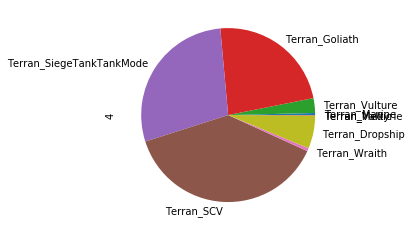

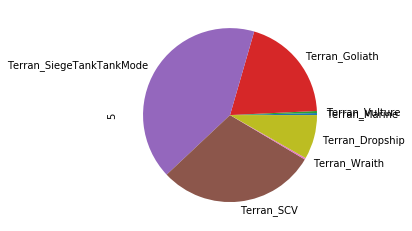

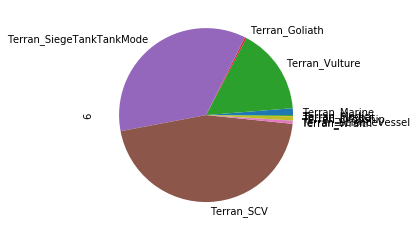

In [10]:
terran_cluster_avg = terran_cluster_df.groupby(['labels']).mean()
for row in range(0,terran_cluster_count):
    plt.figure()
    terran_cluster_avg.iloc[row].T.plot.pie(subplots=True, figsize=(15, 15),layout=(1,1))
    plt.show()

### Protoss

In [11]:
protoss_df = label_unit_df[player_races==2]

In [12]:
from scipy.cluster.hierarchy import dendrogram, linkage

Z = linkage(protoss_df,'ward')
plt.figure(dpi=500,figsize=(30,30))
dendrogram(Z,truncate_mode='mlab',);

In [13]:
from sklearn.cluster import AgglomerativeClustering

clustering = AgglomerativeClustering(linkage='ward', n_clusters=6,distance_threshold=None)
protoss_cluster = clustering.fit_predict(protoss_df)
protoss_cluster_df = protoss_df.copy()
protoss_cluster_df['labels'] = protoss_cluster
protoss_cluster_count = len(protoss_cluster_df['labels'].unique())

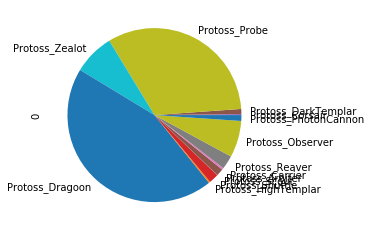

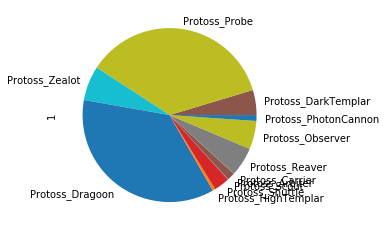

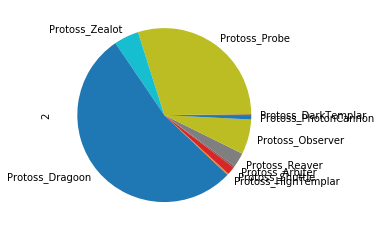

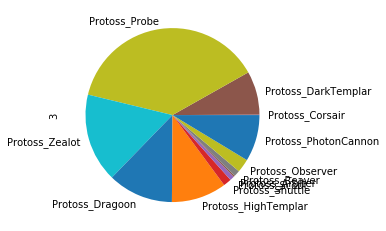

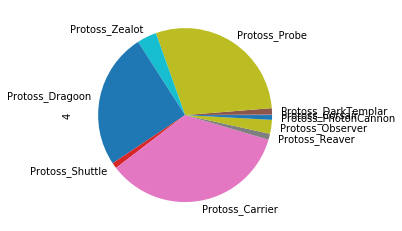

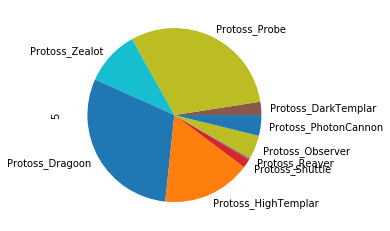

In [14]:
protoss_cluster_avg = protoss_cluster_df.groupby(['labels']).mean()
for row in range(0,protoss_cluster_count):
    plt.figure()
    protoss_cluster_avg.iloc[row].T.plot.pie(subplots=True, figsize=(15, 15),layout=(1,1))
    plt.show()

## Export Clusters and Replays

In [15]:
terran_games = pd.Series(terran_cluster,index=terran_df.index)
protoss_games = pd.Series([int(cluster+max(terran_games)+1) for cluster in protoss_cluster],index=protoss_df.index)

In [16]:
all_games = (pd.DataFrame(pd.concat([terran_games,protoss_games]))
             .merge(player_races,left_index=True,right_index=True))
all_games.columns = ['cluster','race']

In [17]:
cfg.to_pickle(all_games,'clustered_replays')